In [56]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import gensim
import pickle
import nltk
import os

In [57]:
# Load our Players
checkpoint = '__checkpoints'
filename = 'reports_cleaned'

with open(os.path.join(checkpoint, filename + '.pkl'), 'rb') as f:
    df = pickle.load(f)
    
players = list(set(df['Player']))

### Classification using NFL Career Data

In [58]:
# Career NFL Data
path = 'dataset-quarterback_stats'
filename = 'nfl_2006-2021.csv'

nfl = pd.read_csv(os.path.join(path, filename))

In [59]:
nfl.head(3)

,Player,Years,Position,Race,Games,Games Started,Wins,Losses,Draws,Completions,...,4th Quarter Comeback,Game Winning Drives,Rushing Attempts,Rushing Yards,Rushing TDs,Rushing 1D,Longest Run,Rush Yds/Att,Rush Yds/Game,Fumbles
0,A.J. Feeley,3.0,QB,White,10.0,5.0,1.0,4.0,0.0,138.0,...,0.0,1.0,11.0,30.0,0.0,3.0,7.0,2.73,3.00,5.0
1,A.J. McCarron,5.0,QB,White,16.0,4.0,2.0,2.0,0.0,109.0,...,0.0,0.0,22.0,68.0,1.0,6.0,18.0,3.09,4.25,2.0
2,Aaron Brooks,1.0,QB,Non-White,8.0,8.0,0.0,8.0,0.0,110.0,...,0.0,0.0,22.0,124.0,0.0,5.0,23.0,5.64,15.50,5.0


In [60]:
df0 = nfl[nfl['Player'].isin(players)].reset_index(drop=True)

In [61]:
# Split into Training and Test Data
X_train = df0.drop(['Player', 'Position', 'Race'], axis=1)
y_train = np.asarray(df0['Race'].map({'White':0, 'Non-White':1}))

print(X_train.shape)
print(y_train.shape)

(136, 36)
(136,)


In [62]:
model = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.330065
         Iterations 9


In [64]:
# Define function to output plot of the model coefficients

def coefplot(results, figsize=(15, 10), sign=False, title='Coefficients of Features w/ 95% Confidence Intervals', title_fontsize=45, orientation=0):

    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    coef_df = coef_df.rename(columns=coef_df.iloc[0]).drop(0, axis=0).reset_index(drop=True)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])
    
    # Only Significat Features
    if sign:
        coef_df = coef_df[coef_df['P>|z|'].astype(float) < 0.05]

    ### Plot Coefficients ###

    # Labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster' will make bars wide on plot
    sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', 
                 kind='bar', ax=ax, 
                 color='none', fontsize=20, 
                 ecolor='steelblue', capsize=0,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title(title, fontsize=title_fontsize)
    ax.set_ylabel('Coefficients', fontsize=25)
    ax.set_xlabel('', fontsize=25)
    
    # Coefficients
    ax.scatter(x=np.arange(coef_df.shape[0]), 
               marker='o', 
               s=80, 
               y=coef_df['coef'], 
               color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    plt.xticks(rotation=orientation)
    
    return plt.show()

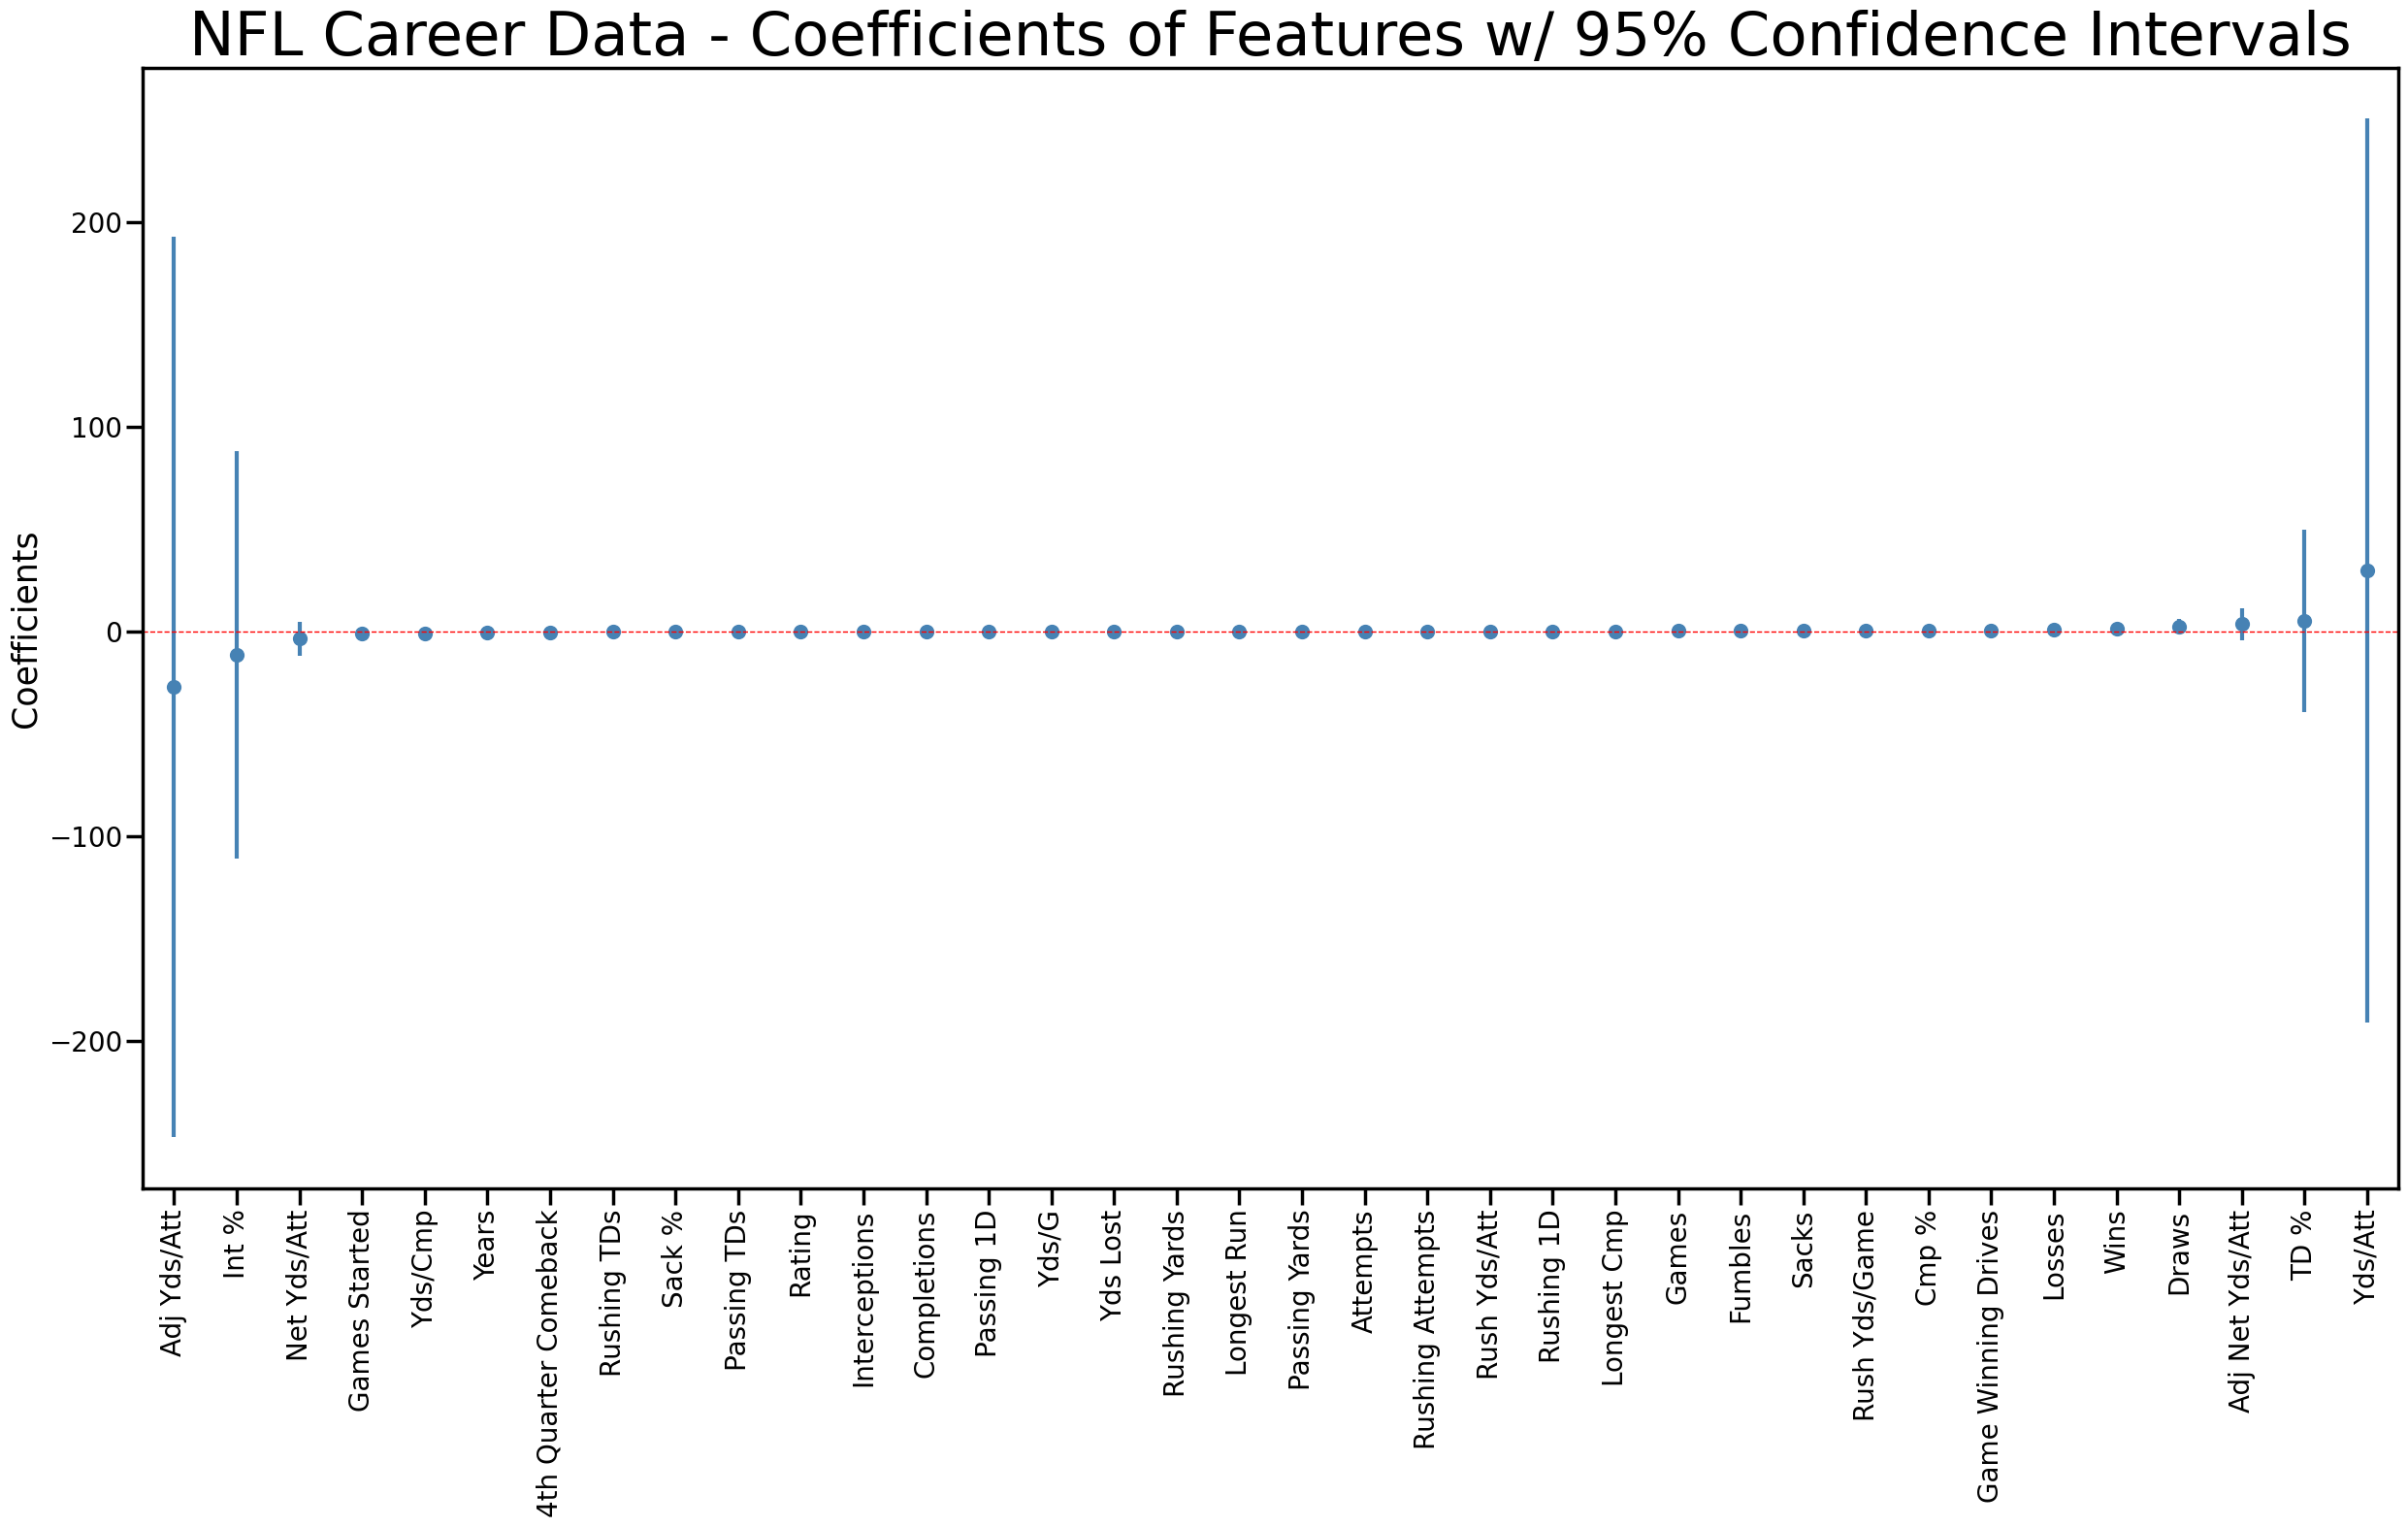

In [65]:
coefplot(model, figsize=(30, 15), sign=False, title='NFL Career Data - Coefficients of Features w/ 95% Confidence Intervals', orientation=90)

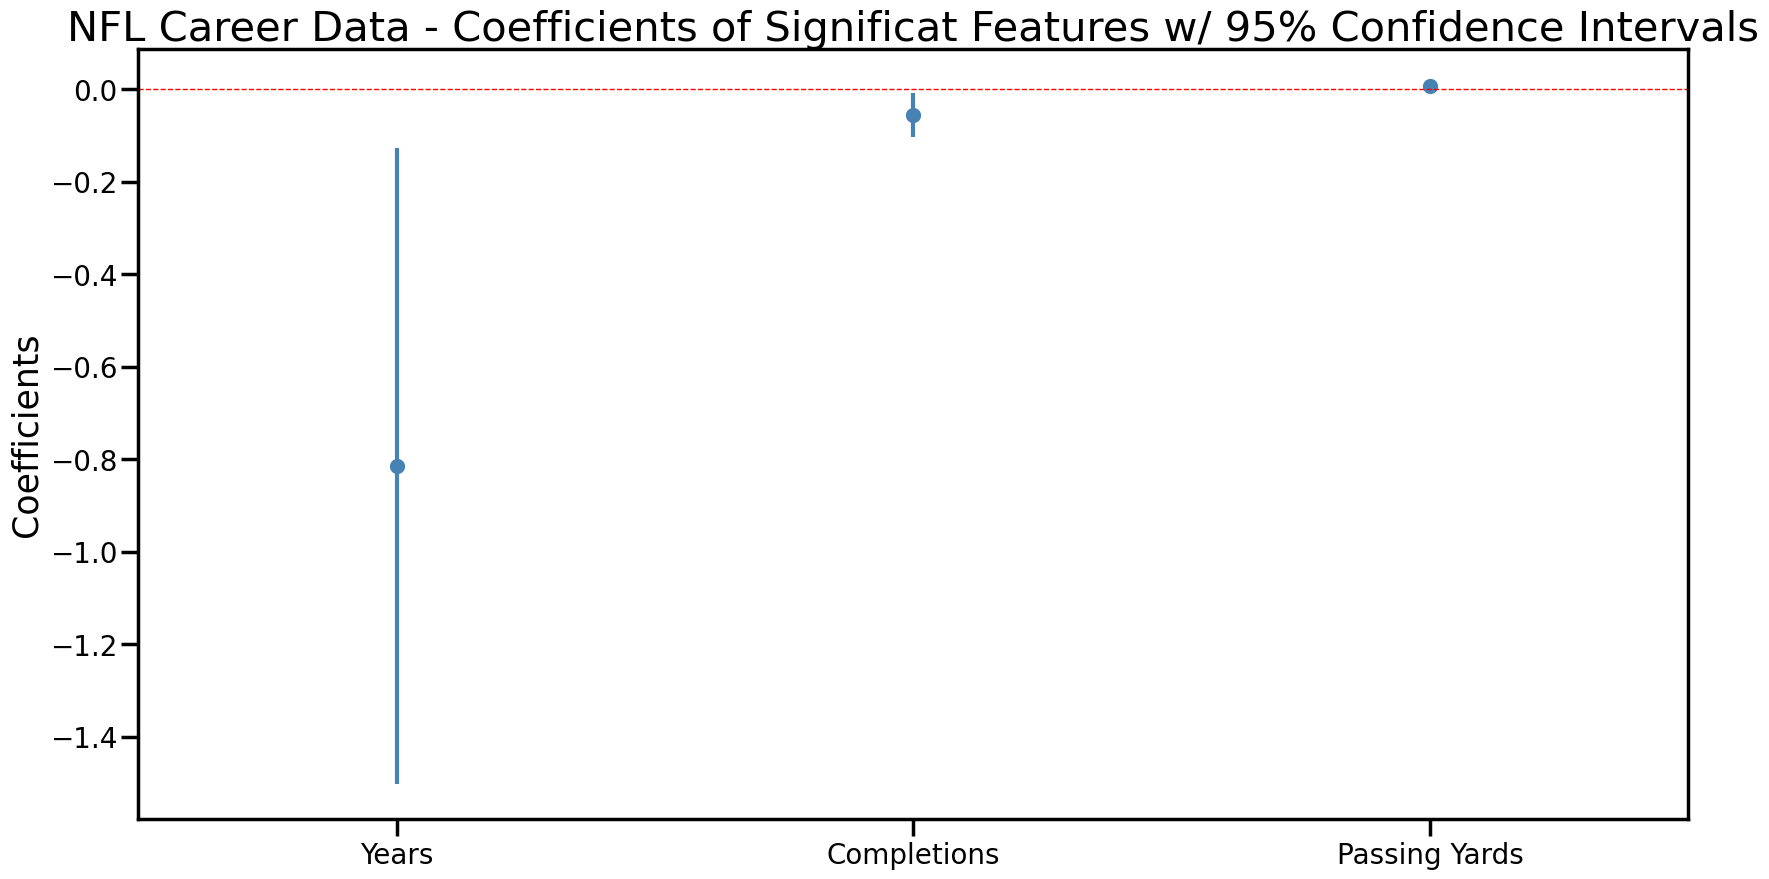

In [21]:
coefplot(model, figsize=(20, 10), sign=True, title='NFL Career Data - Coefficients of Significat Features w/ 95% Confidence Intervals', title_fontsize=30)

In [13]:
coef_df = pd.DataFrame(model.summary().tables[1].data)
coef_df = coef_df.rename(columns=coef_df.iloc[0]).drop(0, axis=0).reset_index(drop=True)
coef_df

,,coef,std err,z,P>|z|,[0.025,0.975]
0,Years,-0.8148,0.351,-2.322,0.020,-1.503,-0.127
1,Games,0.0796,0.071,1.125,0.261,-0.059,0.218
2,Games Started,-1.1276,1.030,-1.095,0.273,-3.146,0.891
3,Wins,1.1690,1.036,1.128,0.259,-0.862,3.200
4,Losses,0.8130,1.053,0.772,0.440,-1.251,2.877
5,Draws,2.3187,1.808,1.282,0.200,-1.226,5.863
6,Completions,-0.0561,0.024,-2.299,0.022,-0.104,-0.008
7,Attempts,0.0129,0.014,0.926,0.354,-0.014,0.040
8,Cmp %,0.2063,0.950,0.217,0.828,-1.656,2.068
9,Passing Yards,0.0063,0.002,2.822,0.005,0.002,0.011


In [14]:
coef_df['coef'] = coef_df['coef'].astype(float) 
coef_df[coef_df['P>|z|'].astype(float) < 0.05].sort_values('coef', ascending=False)

,,coef,std err,z,P>|z|,[0.025,0.975]
9,Passing Yards,0.0063,0.002,2.822,0.005,0.002,0.011
6,Completions,-0.0561,0.024,-2.299,0.022,-0.104,-0.008
0,Years,-0.8148,0.351,-2.322,0.020,-1.503,-0.127


### Classification using Seasonal NFL Data

In [22]:
path = 'dataset-quarterback_stats'
filename = 'census.csv'

census = pd.read_csv(os.path.join(path, filename))

In [23]:
path = 'dataset-quarterback_stats/nfl_datasets'
years = list(range(2006, 2022))
league = 'nfl'

dfs = [pd.read_csv(os.path.join(path, league + '_' + str(year) +'.csv')) for year in years]
df = pd.concat(dfs).reset_index(drop=True)
df.fillna(0, inplace=True)
df.head(5)

,Player,Year,Team,Age,Position,Games,Games Started,Wins,Losses,Draws,...,4th Quarter Comeback,Game Winning Drives,Rushing Attempts,Rushing Yards,Rushing TDs,Rushing 1D,Longest Run,Rush Yds/Att,Rush Yds/Game,Fumbles
0,Drew Brees,2006,NOR,27,QB,16,16,10,6,0,...,1.0,2.0,42,32,0,5,16,0.8,2.0,8
1,Peyton Manning,2006,IND,30,QB,16,16,12,4,0,...,3.0,3.0,23,36,4,7,12,1.6,2.3,2
2,Marc Bulger,2006,STL,29,QB,16,16,8,8,0,...,2.0,3.0,18,44,0,5,29,2.4,2.8,6
3,Jon Kitna,2006,DET,34,QB,16,16,3,13,0,...,1.0,1.0,34,156,2,9,18,4.6,9.8,11
4,Carson Palmer,2006,CIN,27,QB,16,16,8,8,0,...,2.0,3.0,26,37,0,6,11,1.4,2.3,15


In [24]:
df1 = df[df['Player'].isin(players)].reset_index(drop=True)
df1 = df1.merge(census, how='left', on='Player')
df1

,Player,Year,Team,Age,Position,Games,Games Started,Wins,Losses,Draws,...,Game Winning Drives,Rushing Attempts,Rushing Yards,Rushing TDs,Rushing 1D,Longest Run,Rush Yds/Att,Rush Yds/Game,Fumbles,Race
0,Matt Leinart,2006,ARI,23,QB,12,11,4,7,0,...,1.0,22,49,2,6,14,2.2,4.1,8,White
1,Vince Young,2006,TEN,23,QB,15,13,8,5,0,...,5.0,83,552,7,32,39,6.7,36.8,12,Non-White
2,Brett Basanez,2006,CAR,23,QB,1,0,0,0,0,...,0.0,1,2,0,0,2,2.0,2.0,0,White
3,Vince Young,2007,TEN,24,QB,15,15,9,6,0,...,0.0,93,395,3,26,21,4.2,26.3,10,Non-White
4,Trent Edwards,2007,BUF,24,QB,10,9,5,4,0,...,2.0,14,49,0,4,14,3.5,4.9,4,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,Josh Rosen,2021,ATL,24,QB,4,0,0,0,0,...,0.0,0,0,0,0,0,0.0,0.0,0,White
520,Kellen Mond,2021,MIN,22,QB,1,0,0,0,0,...,0.0,0,0,0,0,0,0.0,0.0,0,Non-White
521,Marcus Mariota,2021,LVR,28,QB,10,0,0,0,0,...,0.0,13,87,1,6,31,6.7,8.7,1,Non-White
522,Feleipe Franks,2021,ATL,24,QB,9,0,0,0,0,...,0.0,3,6,0,0,4,2.0,0.7,0,Non-White


In [25]:
# Split into Training and Test Data
X_train = df1.drop(['Player', 'Year', 'Team', 'Position', 'Race'], axis=1)
y_train = np.asarray(df1['Race'].map({'White':0, 'Non-White':1}))

print(X_train.shape)
print(y_train.shape)

(524, 37)
(524,)


In [26]:
model = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.483415
         Iterations 7


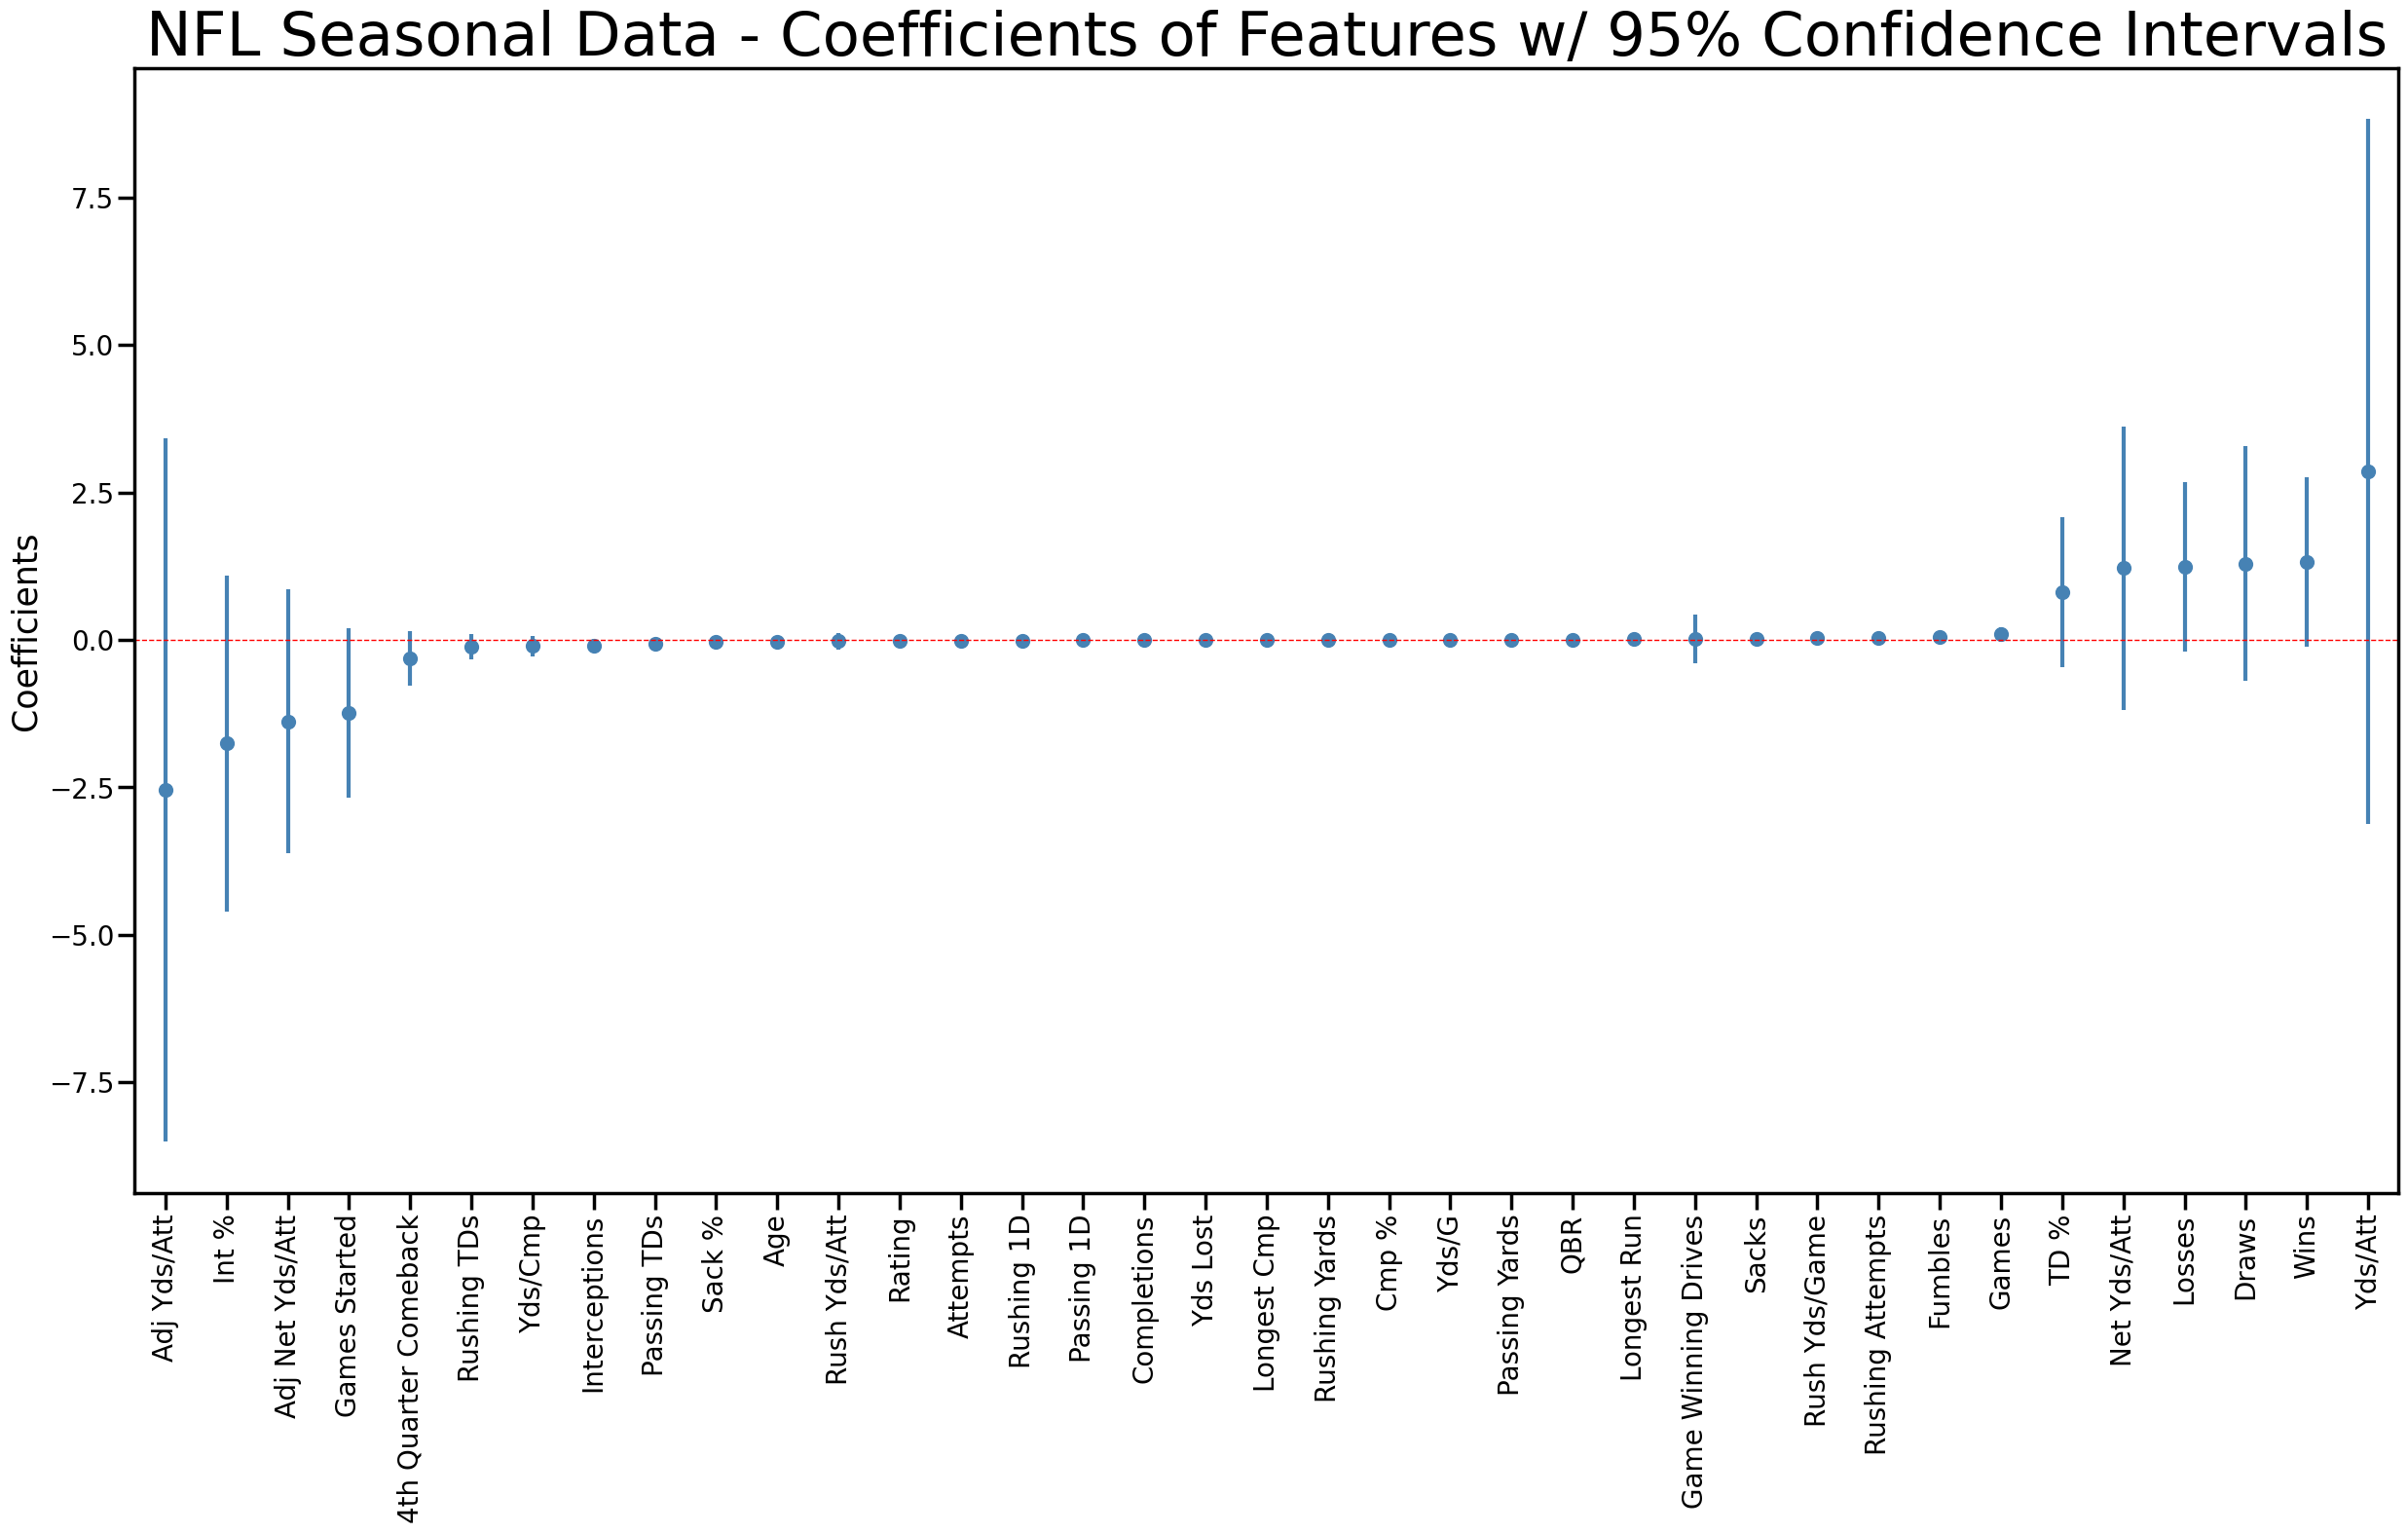

In [28]:
coefplot(model, figsize=(30, 15), sign=False, title='NFL Seasonal Data - Coefficients of Features w/ 95% Confidence Intervals', orientation=90)

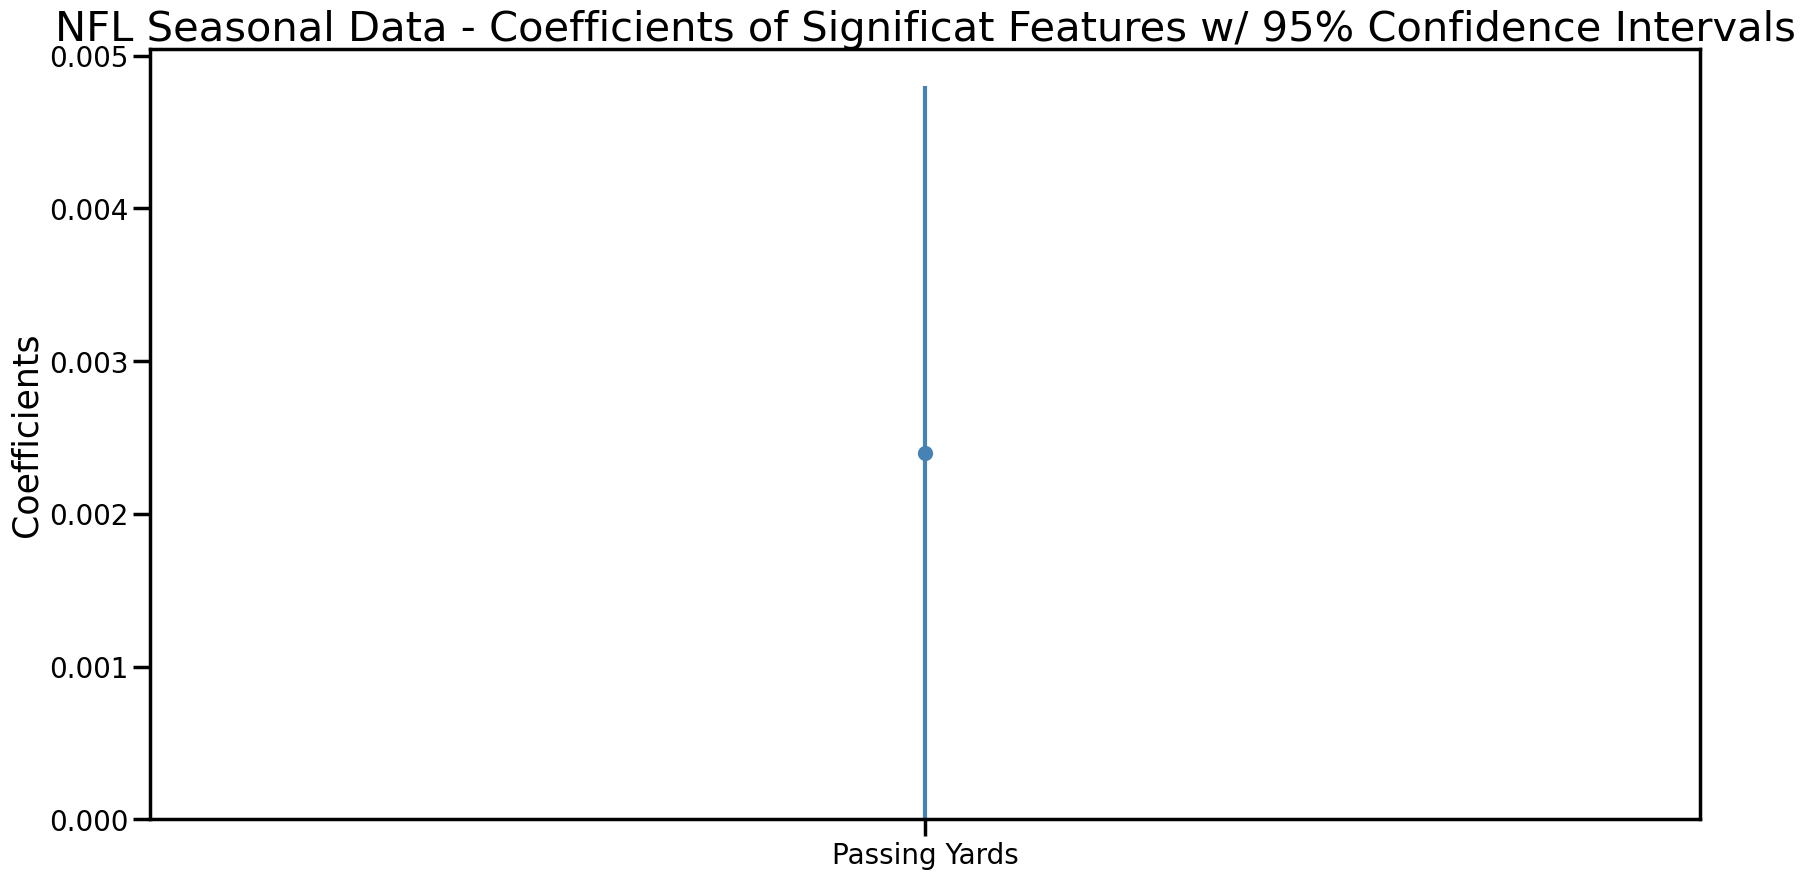

In [31]:
coefplot(model, figsize=(20, 10), sign=True, title='NFL Seasonal Data - Coefficients of Significat Features w/ 95% Confidence Intervals', title_fontsize=30)

In [32]:
coef_df = pd.DataFrame(model.summary().tables[1].data)
coef_df = coef_df.rename(columns=coef_df.iloc[0]).drop(0, axis=0).reset_index(drop=True)
coef_df

,,coef,std err,z,P>|z|,[0.025,0.975]
0,Age,-0.0286,0.028,-1.030,0.303,-0.083,0.026
1,Games,0.0982,0.064,1.533,0.125,-0.027,0.224
2,Games Started,-1.2357,0.730,-1.692,0.091,-2.667,0.196
3,Wins,1.3176,0.731,1.803,0.071,-0.115,2.750
4,Losses,1.2419,0.731,1.699,0.089,-0.191,2.675
5,Draws,1.2966,1.017,1.274,0.202,-0.697,3.291
6,Completions,-0.0065,0.013,-0.500,0.617,-0.032,0.019
7,Attempts,-0.0135,0.008,-1.597,0.110,-0.030,0.003
8,Cmp %,0.0018,0.015,0.115,0.908,-0.028,0.032
9,Passing Yards,0.0024,0.001,2.442,0.015,0.000,0.004


In [34]:
coef_df['coef'] = coef_df['coef'].astype(float) 
coef_df[coef_df['P>|z|'].astype(float) < 0.05].sort_values('coef', ascending=False)

,,coef,std err,z,P>|z|,[0.025,0.975]
9,Passing Yards,0.0024,0.001,2.442,0.015,0.000,0.004


### Classification using College Career Data

In [35]:
# Career College Data
path = 'dataset-quarterback_stats'
filename = 'cfb_2006-2021.csv'

cfb = pd.read_csv(os.path.join(path, filename))

In [36]:
df2 = cfb[cfb['Player'].isin(players)].reset_index(drop=True)
df2 = df2.merge(census, how='left', on='Player')
df2

,Player,Years,Completions,Attempts,Completion %,Passing Yards,Yds/Att,Adj Yds/Att,Passing TDs,Interceptions,Rating,Rushing Attempts,Rushing Yards,Rush Yds/Att,Rushing TDs,Race
0,Mike White,3,770,1218,0.63,10179,8.36,8.71,71,22,149.04,122,-427,0.0,6,White
1,Brandon Weeden,2,751,1076,0.70,9004,8.37,8.60,71,26,157.03,34,-170,0.0,1,White
2,Shane Carden,3,1052,1579,0.67,11991,7.59,7.83,86,30,144.59,271,253,0.0,24,White
3,Pat White,2,324,490,0.66,3566,7.28,7.70,35,11,146.34,388,2309,0.0,22,Non-White
4,JaMarcus Russell,1,232,342,0.68,3129,9.15,9.73,28,8,167.03,52,142,0.0,1,Non-White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,Hunter Cantwell,1,221,377,0.59,2493,6.61,5.55,16,16,119.68,39,-115,0.0,1,White
240,Todd Boeckman,1,191,299,0.64,2379,7.96,7.52,25,14,148.94,56,63,0.0,0,White
241,Case Keenum,4,1504,2165,0.69,18581,8.58,9.12,150,41,160.64,296,826,0.0,23,White
242,Keith Price,3,738,1146,0.64,8757,7.64,7.74,73,30,144.37,207,84,0.0,10,Non-White


In [37]:
# Split into Training and Test Data
X_train = df2.drop(['Player', 'Race', 'Rush Yds/Att'], axis=1)
y_train = np.asarray(df2['Race'].map({'White':0, 'Non-White':1}))

print(X_train.shape)
print(y_train.shape)

(244, 13)
(244,)


In [38]:
model = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.512907
         Iterations 6


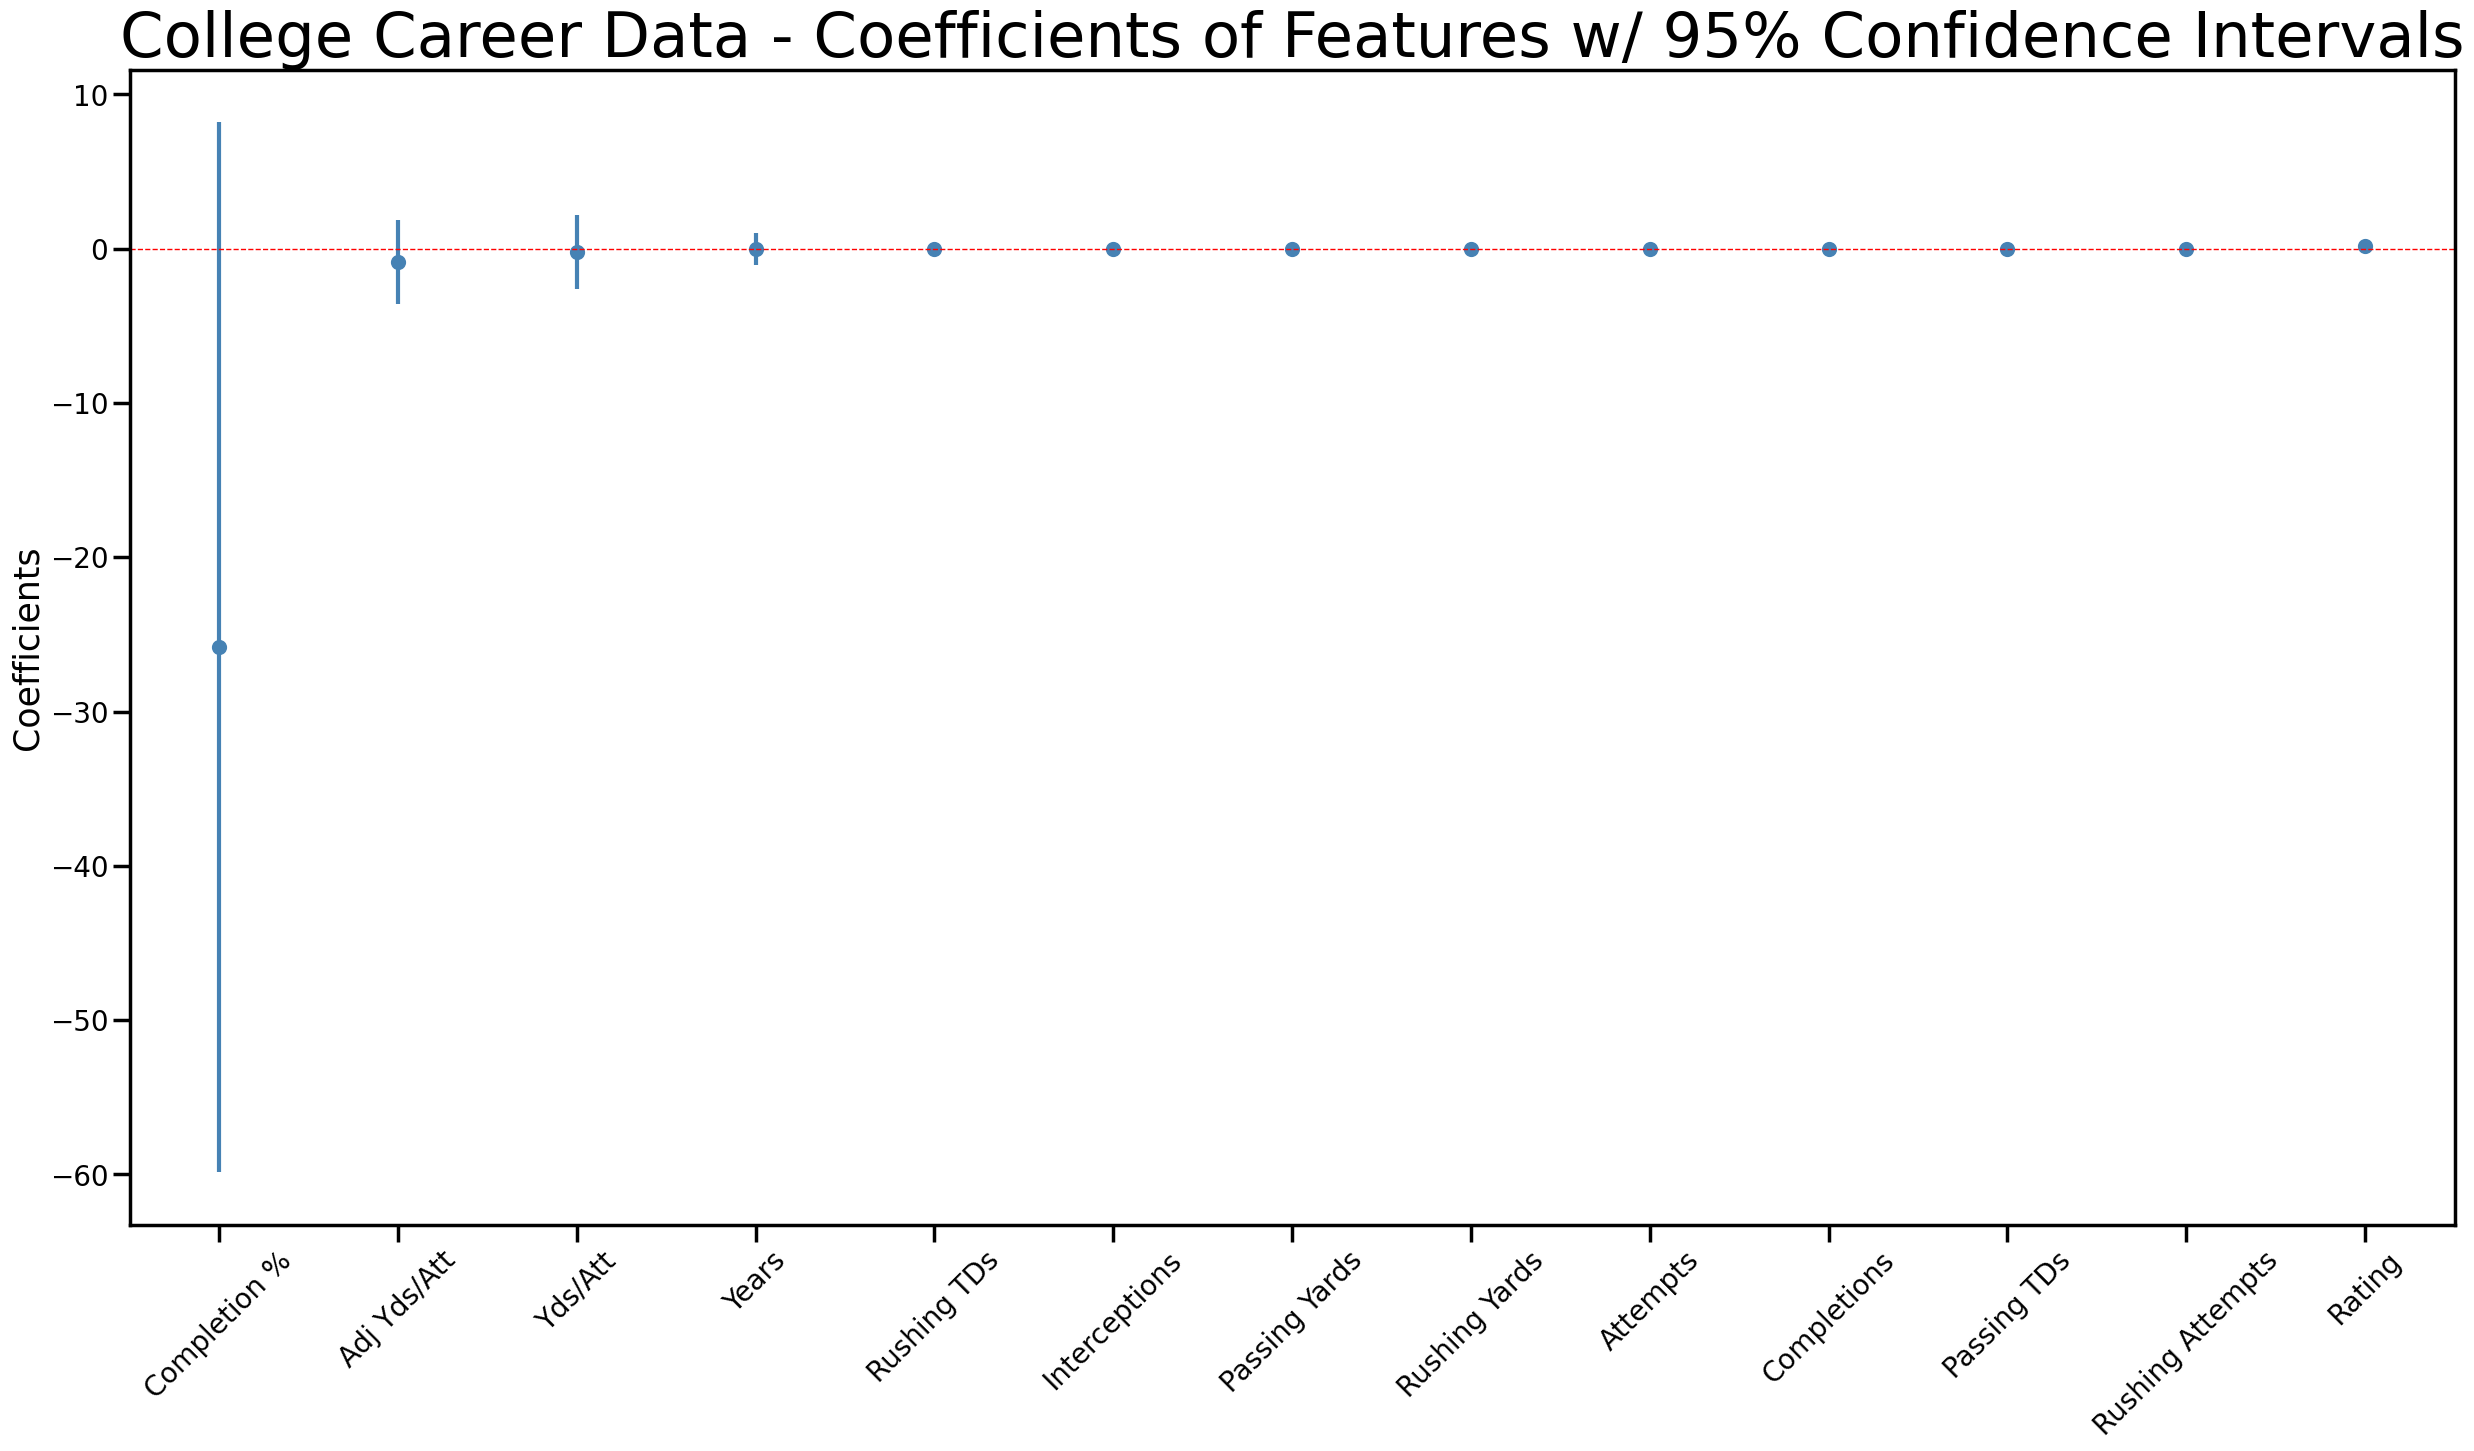

In [42]:
coefplot(model, figsize=(30, 15), sign=False, title='College Career Data - Coefficients of Features w/ 95% Confidence Intervals', orientation=45)

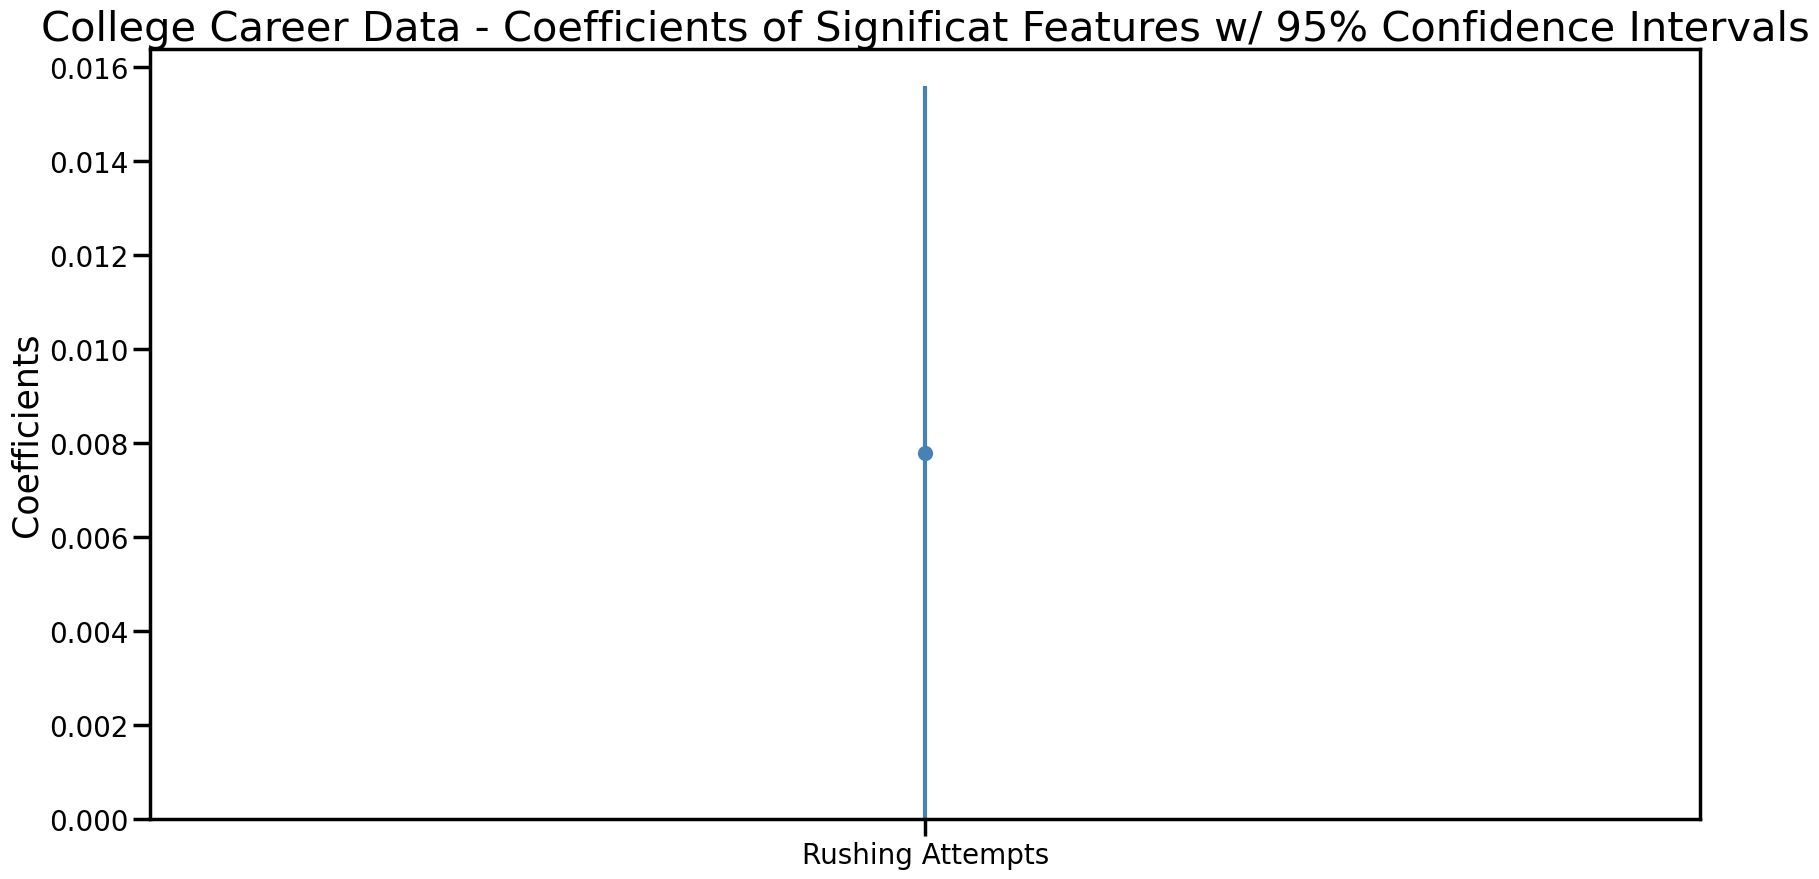

In [44]:
coefplot(model, figsize=(20, 10), sign=True, title='College Career Data - Coefficients of Significat Features w/ 95% Confidence Intervals', title_fontsize=30)

In [45]:
coef_df = pd.DataFrame(model.summary().tables[1].data)
coef_df = coef_df.rename(columns=coef_df.iloc[0]).drop(0, axis=0).reset_index(drop=True)
coef_df

,,coef,std err,z,P>|z|,[0.025,0.975]
0,Years,-0.0134,0.541,-0.025,0.980,-1.074,1.048
1,Completions,0.0029,0.009,0.313,0.754,-0.015,0.021
2,Attempts,0.0007,0.004,0.176,0.860,-0.007,0.009
3,Completion %,-25.8402,17.362,-1.488,0.137,-59.870,8.190
4,Passing Yards,-0.0006,0.001,-0.654,0.513,-0.002,0.001
5,Yds/Att,-0.2250,1.231,-0.183,0.855,-2.638,2.188
6,Adj Yds/Att,-0.8612,1.404,-0.613,0.540,-3.614,1.891
7,Passing TDs,0.0032,0.047,0.068,0.946,-0.089,0.095
8,Interceptions,-0.0015,0.059,-0.026,0.980,-0.118,0.114
9,Rating,0.1668,0.166,1.006,0.314,-0.158,0.492


In [46]:
coef_df['coef'] = coef_df['coef'].astype(float) 
coef_df[coef_df['P>|z|'].astype(float) < 0.05].sort_values('coef', ascending=False)

,,coef,std err,z,P>|z|,[0.025,0.975]
10,Rushing Attempts,0.0078,0.004,1.999,0.046,0.000,0.015


### Classification using College Seasonal Data

In [47]:
path = 'dataset-quarterback_stats/cfb_datasets'
years = list(range(2006, 2022))
league = 'cfb'

dfs = [pd.read_csv(os.path.join(path, league + '_' + str(year) +'.csv')) for year in years]
df = pd.concat(dfs).reset_index(drop=True)
df.fillna(0, inplace=True)
df.head(5)

,Player,School,Conference,Games,Completions,Attempts,Completion %,Passing Yards,Yds/Att,Adj Yds/Att,Passing TDs,Interceptions,Rating,Rushing Attempts,Rushing Yards,Rush Yds/Att,Rushing TDs
0,Colt Brennan,Hawaii,WAC,14,406,559,72.6,5549,9.9,11.0,58,12,186.0,86,366,4.3,5
1,Brian Brohm,Louisville,Big East,11,199,313,63.6,3049,9.7,10.0,16,5,159.1,47,45,1.0,0
2,John Beck,Brigham Young,MWC,12,289,417,69.3,3885,9.3,10.0,32,8,169.1,50,-8,-0.2,6
3,JaMarcus Russell,LSU,SEC,13,232,342,67.8,3129,9.1,9.7,28,8,167.0,52,142,2.7,1
4,Jared Zabransky,Boise State,WAC,13,191,288,66.3,2587,9.0,9.3,23,8,162.6,98,197,2.0,6


In [48]:
df3 = df[df['Player'].isin(players)].reset_index(drop=True)
df3 = df3.merge(census, how='left', on='Player')
df3

,Player,School,Conference,Games,Completions,Attempts,Completion %,Passing Yards,Yds/Att,Adj Yds/Att,Passing TDs,Interceptions,Rating,Rushing Attempts,Rushing Yards,Rush Yds/Att,Rushing TDs,Race
0,Brian Brohm,Louisville,Big East,11,199,313,63.6,3049,9.7,10.0,16,5,159.1,47,45,1.0,0,White
1,John Beck,Brigham Young,MWC,12,289,417,69.3,3885,9.3,10.0,32,8,169.1,50,-8,-0.2,6,White
2,JaMarcus Russell,LSU,SEC,13,232,342,67.8,3129,9.1,9.7,28,8,167.0,52,142,2.7,1,Non-White
3,Jared Zabransky,Boise State,WAC,13,191,288,66.3,2587,9.0,9.3,23,8,162.6,98,197,2.0,6,White
4,Tyler Palko,Pitt,Big East,12,220,322,68.3,2871,8.9,9.2,25,9,163.2,66,77,1.2,2,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,Shane Buechele,SMU,American,10,242,370,65.4,3095,8.4,8.9,23,6,152.9,58,105,1.8,2,White
556,Ian Book,Notre Dame,ACC,12,228,353,64.6,2830,8.0,8.5,15,3,144.3,116,485,4.2,9,White
557,Sam Ehlinger,Texas,Big 12,10,194,322,60.2,2566,8.0,8.9,26,5,150.7,113,377,3.3,8,White
558,Kellen Mond,Texas A&M,SEC,10,188,297,63.3,2282,7.7,8.5,19,3,146.9,74,294,4.0,4,Non-White


In [49]:
# Split into Training and Test Data
X_train = df3.drop(['Player', 'Race', 'School', 'Conference'], axis=1)
y_train = np.asarray(df3['Race'].map({'White':0, 'Non-White':1}))

print(X_train.shape)
print(y_train.shape)

(560, 14)
(560,)


In [50]:
model = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.509984
         Iterations 6


In [51]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  560
Model:                          Logit   Df Residuals:                      546
Method:                           MLE   Df Model:                           13
Date:                Sat, 11 Feb 2023   Pseudo R-squ.:                  0.1476
Time:                        22:28:30   Log-Likelihood:                -285.59
converged:                       True   LL-Null:                       -335.03
Covariance Type:            nonrobust   LLR p-value:                 2.734e-15
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Games               -0.0166      0.098     -0.169      0.866      -0.209       0.176
Completions          0.0133      0.019      0.704      0.482      -0.024       0.050
Attempts            -0.0014 

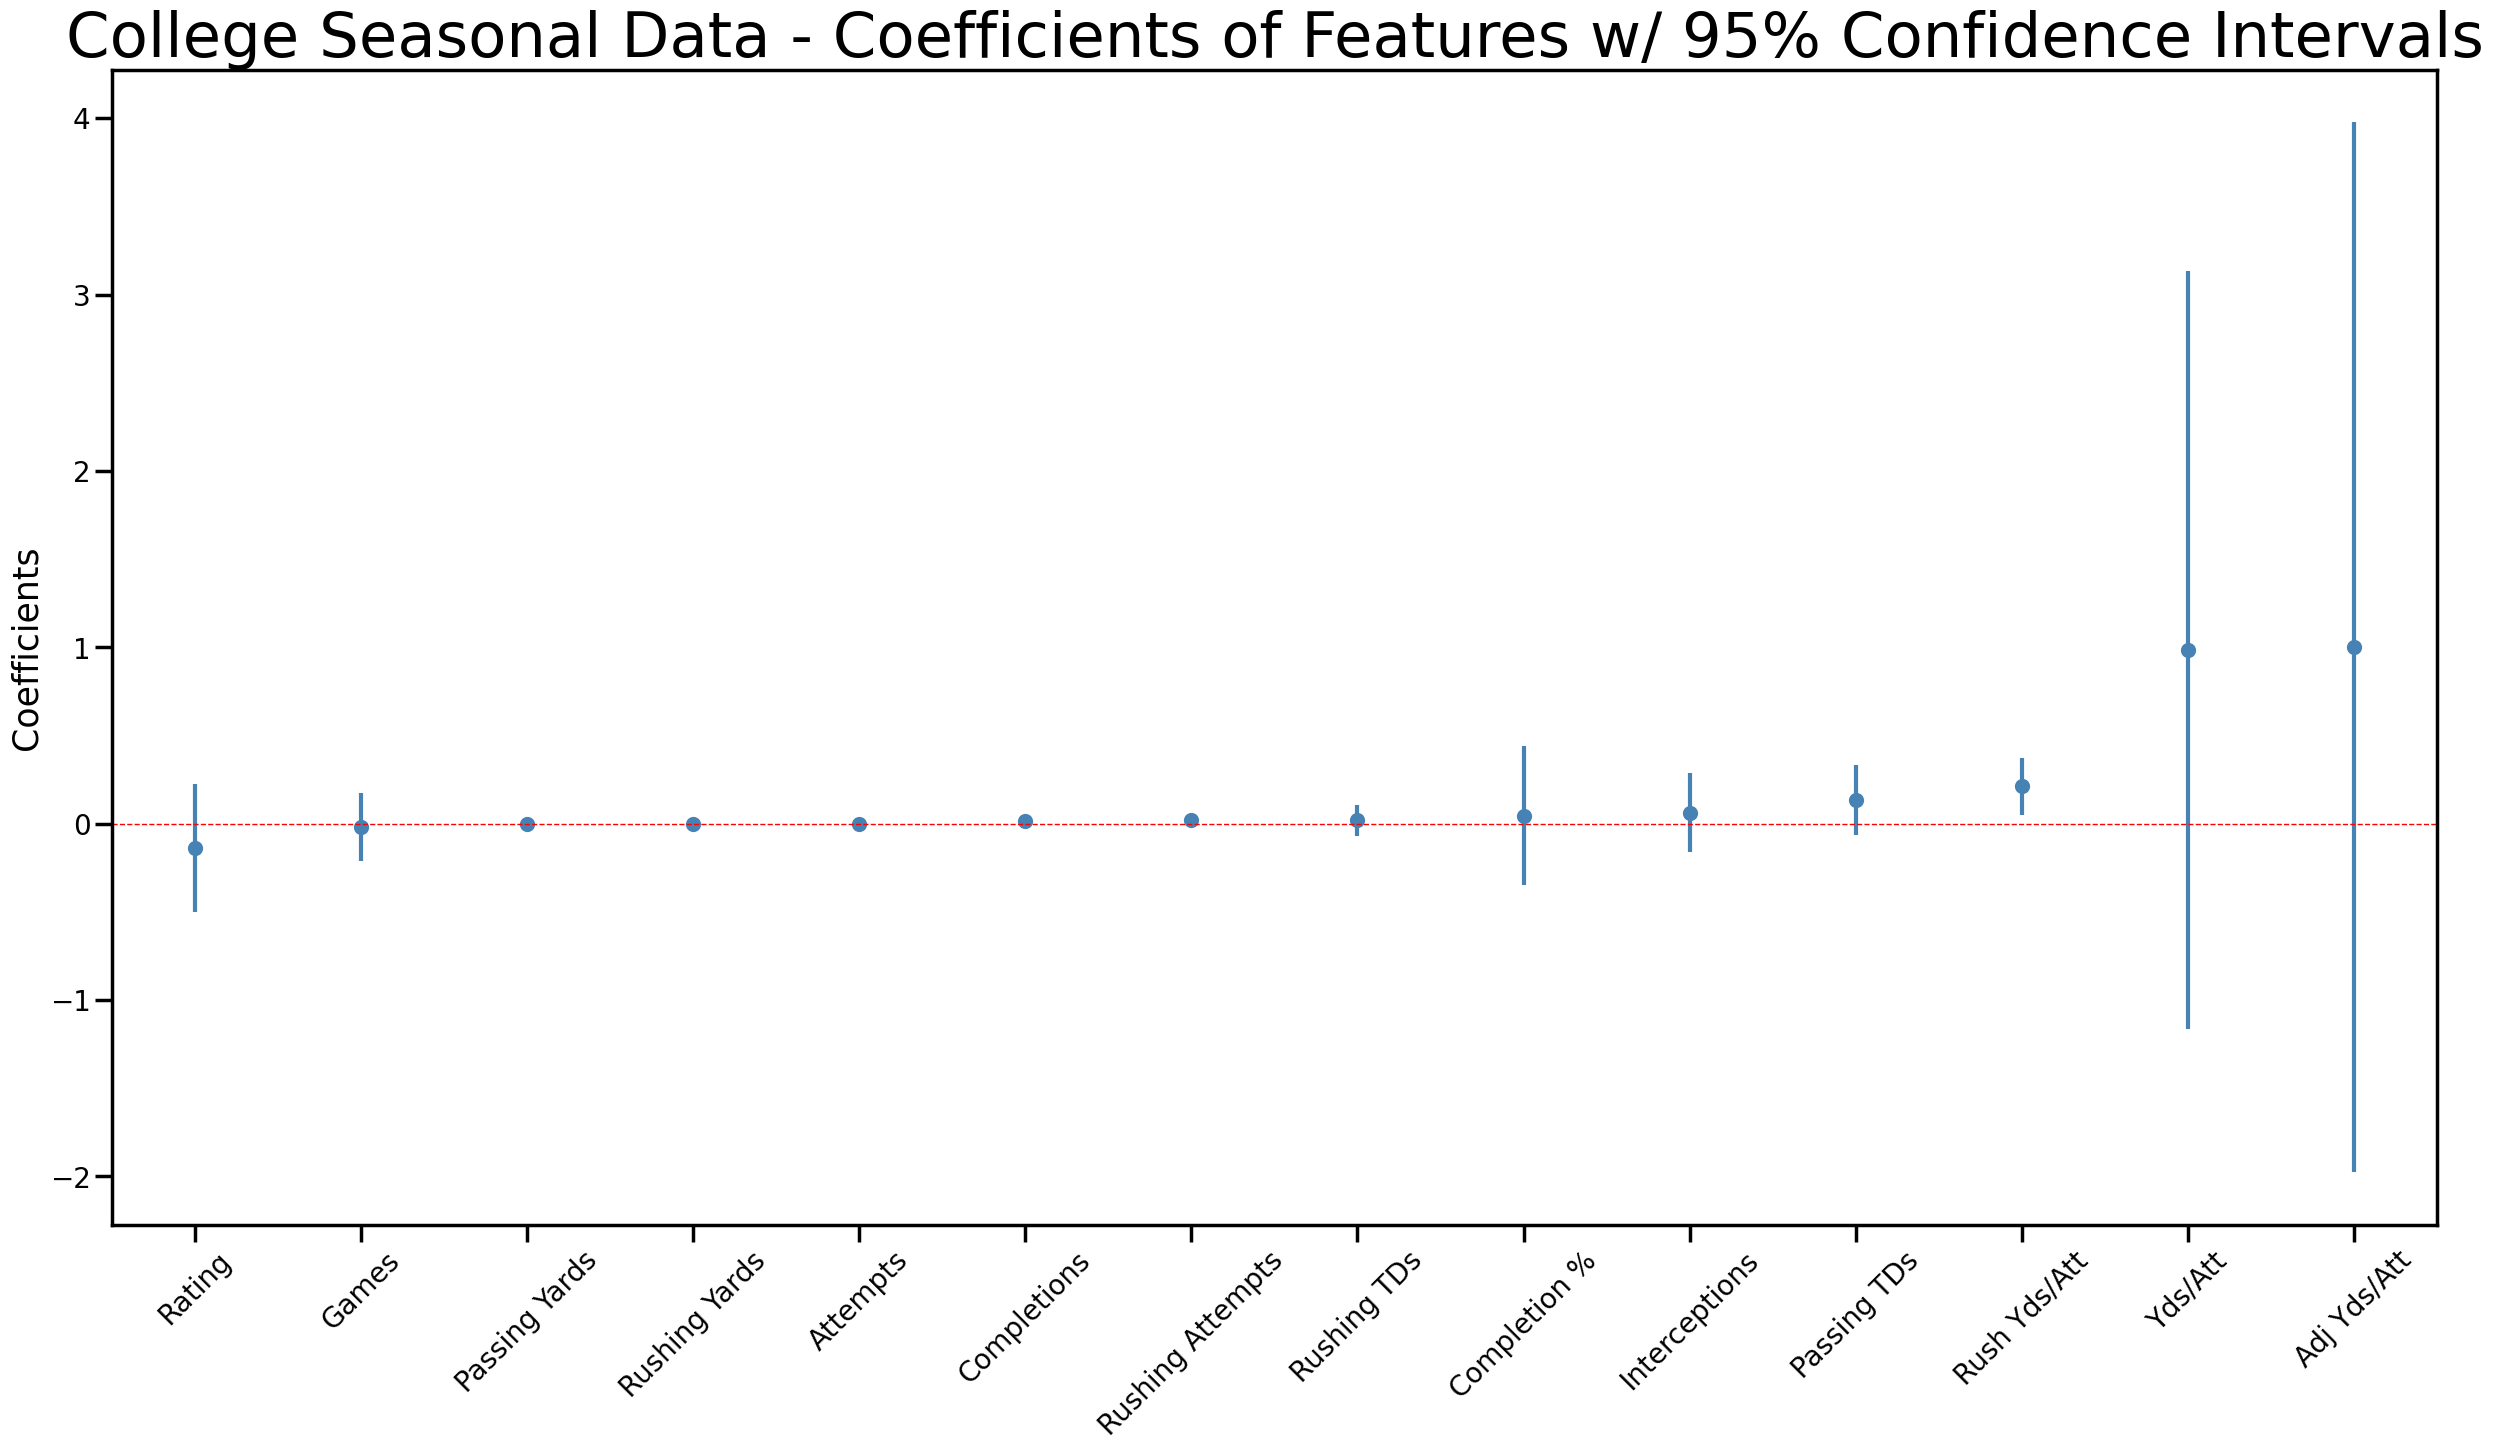

In [52]:
coefplot(model, figsize=(30, 15), sign=False, title='College Seasonal Data - Coefficients of Features w/ 95% Confidence Intervals', orientation=45)


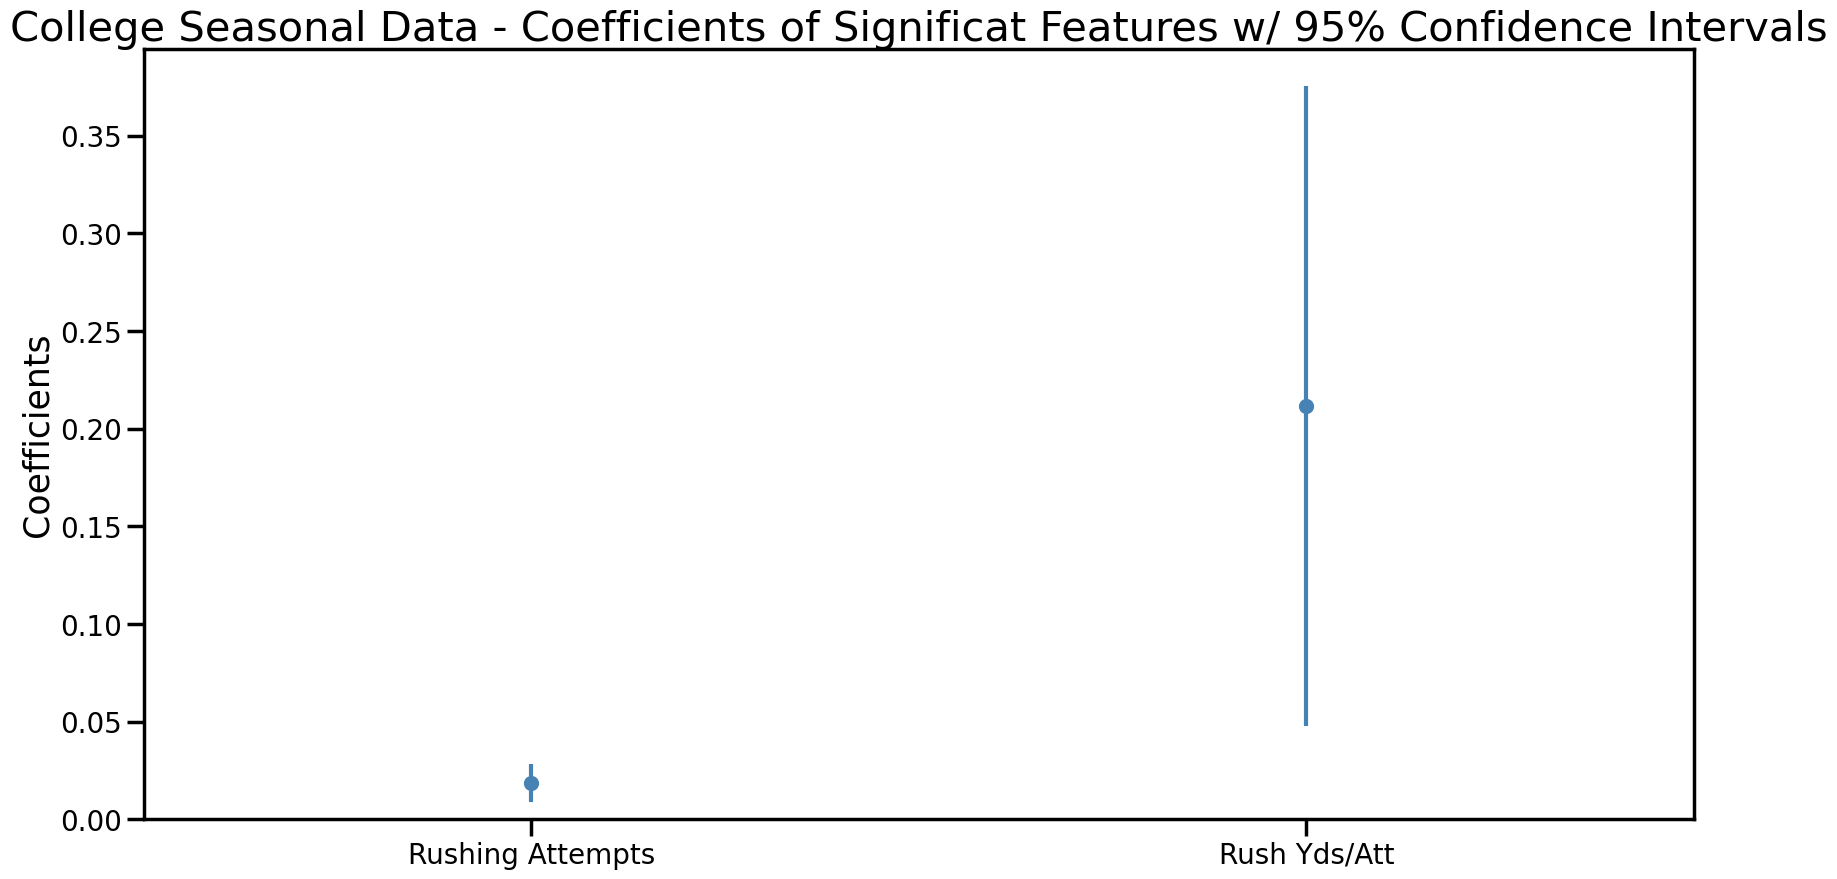

In [53]:
coefplot(model, figsize=(20, 10), sign=True, title='College Seasonal Data - Coefficients of Significat Features w/ 95% Confidence Intervals', title_fontsize=30)

In [54]:
coef_df = pd.DataFrame(model.summary().tables[1].data)
coef_df = coef_df.rename(columns=coef_df.iloc[0]).drop(0, axis=0).reset_index(drop=True)
coef_df

,,coef,std err,z,P>|z|,[0.025,0.975]
0,Games,-0.0166,0.098,-0.169,0.866,-0.209,0.176
1,Completions,0.0133,0.019,0.704,0.482,-0.024,0.050
2,Attempts,-0.0014,0.005,-0.259,0.796,-0.012,0.009
3,Completion %,0.0460,0.201,0.229,0.819,-0.348,0.440
4,Passing Yards,-0.0026,0.002,-1.483,0.138,-0.006,0.001
5,Yds/Att,0.9849,1.096,0.899,0.369,-1.163,3.133
6,Adj Yds/Att,1.0001,1.519,0.658,0.510,-1.977,3.977
7,Passing TDs,0.1349,0.102,1.320,0.187,-0.065,0.335
8,Interceptions,0.0624,0.115,0.542,0.588,-0.163,0.288
9,Rating,-0.1370,0.185,-0.742,0.458,-0.499,0.225


In [55]:
coef_df['coef'] = coef_df['coef'].astype(float) 
coef_df[coef_df['P>|z|'].astype(float) < 0.05].sort_values('coef', ascending=False)

,,coef,std err,z,P>|z|,[0.025,0.975]
12,Rush Yds/Att,0.2117,0.083,2.540,0.011,0.048,0.375
10,Rushing Attempts,0.0188,0.005,3.619,0.000,0.009,0.029
